In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.autograd import Variable
from torch.utils import data
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms
from torchvision import datasets

import numpy as np

from matplotlib import pyplot as plt
from pandas import read_fwf, DataFrame
from tqdm   import tqdm_notebook as tqdm
import matplotlib.gridspec as gridspec


from skimage import exposure
from skimage import measure
from skimage.io import imsave
from skimage.filters import gaussian as gaussian_filter
from skimage.filters import threshold_otsu
from skimage import filters
from skimage.morphology import opening, closing, disk, binary_dilation, flood
from sklearn.model_selection import train_test_split

In [8]:
sys.path.append('../')
from VAE.rg_dataset import LRG, BasicDataset, get_datasets

In [9]:
batch_size = 32
aug = 10
data_path = '../data/'
device = 'cuda'

In [1]:
# lrg_data_set   = LRG(112, rd_sz=128, use_kittler=True, n_aug=aug, blur=False, 
#                      catalog_dir=data_path + 'catalog/mrt-table3.txt', 
#                      file_dir=data_path + 'lrg')

lrg_datasets = get_datasets(112, rd_sz=128, n_aug=10) 

NameError: name 'get_datasets' is not defined

In [18]:
# x, y = lrg_data_set.get_data()
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [19]:
# train_dataset = BasicDataset(X_train, y_train, n_aug=15, sz=112) #
# test_dataset  = BasicDataset(X_test,  y_test,  n_aug=5,  sz=112)

train_dataloader = data.DataLoader(lrg_datasets['train'], batch_size=batch_size, shuffle=True)
test_dataloader  = data.DataLoader(lrg_datasets['test'],  batch_size=batch_size, shuffle=True)

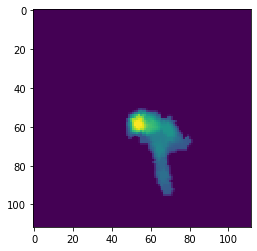

In [20]:
sample = iter(test_dataloader).next()
plt.imshow(sample[0].numpy()[0][0])
plt.show()

In [21]:
class DeepClassifier(nn.Module):
    ''' Somewhat inspired in VGG'''
    def __init__(self, k=None, num_classes=6, lt_dim=8, batchnorm=True, in_channels=1, non_linearity=nn.ReLU,
                 Conv2d=nn.Conv2d, MaxPool2d=nn.MaxPool2d, BatchNorm2d=nn.BatchNorm2d, n_angles=1):
        super(DeepClassifier, self).__init__()
        
        self.non_linearity = non_linearity
        self.Conv2d = Conv2d
        self.MaxPool2d = MaxPool2d
        self.BatchNorm2d = BatchNorm2d
        self.n_angles = n_angles
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(k[-2] * 7 * 7, lt_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(lt_dim, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        
        if k == None:
            k = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

        layers = self.__make_layers(k, batchnorm)
        self.features = nn.Sequential(*layers)
        self._initialize_weights()

    def __make_layers(self, k, batch_norm, in_channels=1):
        layers = []
        for v in k:
            if v == 'M' :
                layers += [self.MaxPool2d(kernel_size=2, stride=2)]
            else :
                conv2d = self.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, self.BatchNorm2d(v), self.non_linearity(inplace=True)]
                else:
                    layers += [conv2d, self.non_linearity(inplace=True)]
                in_channels = v
#         for l in layers: print(l)
        return layers

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
                
    def rotate_input(self, x, angle):
        if angle == 0 or angle == 360 :
            return x
        bsz = x.shape[0]

        r = torch.zeros([bsz, 2, 3], dtype=torch.float32, device='cuda')
        r[:, 0, 0] =    torch.cos(torch.FloatTensor(bsz).fill_(angle))
        r[:, 0, 1] =    torch.sin(torch.FloatTensor(bsz).fill_(angle))
        r[:, 1, 0] = -1*torch.sin(torch.FloatTensor(bsz).fill_(angle))
        r[:, 1, 1] =    torch.cos(torch.FloatTensor(bsz).fill_(angle))
        
        grid = F.affine_grid(r, x.size()).cuda()
        x = F.grid_sample(x, grid, padding_mode='zeros')
        return x

    def forward(self, x):
        ys = []
        angle_steps = 360/self.n_angles
        angle = 0
        for a in range(self.n_angles):
            x = self.rotate_input(x, angle)
            y = self.features(x)
            y = self.avgpool(y)
            y = torch.flatten(y, 1)
            y = self.classifier(y)
#             y = F.softmax(y)
            ys.append(y)
            angle += angle_steps
        y = torch.mean(torch.stack(ys), dim=0)
        return y

'''Common configs for VGG like networks'''
cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M'],
}

In [22]:
def train(model, dataloader, optimizer, epoch, criterion):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # backward + optimize
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
        s = 'Train Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\tTrain Acc: {:.4f}'
        s = s.format(epoch,
                100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
        sys.stdout.write('{}\r'.format(s))
        sys.stdout.flush()
    return running_loss, running_corrects, s

In [23]:
def test(model, dataloader, optimizer, epoch, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    running_inputs=0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        running_inputs += len(labels.data)
        
        running_acc = (1.0 * running_corrects)/running_inputs
        
#         s = 'Test Epoch: {:3d} ({:3.0f}%)\tLoss:\t{:4.4f}\trLoss: {:4.2f}\trPreds: {:.4f}'
#         s = s.format(epoch,
#                 100. * batch_idx / len(dataloader), loss.item(), running_loss, running_acc)
#         sys.stdout.write('{}\r'.format(s))
#         sys.stdout.flush()

    return running_loss, running_acc#, s

In [24]:
epochs = 100
lr = 0.0001

In [26]:
k = [16, 'M', 32, 'M', 64, 64, 'M', 128, 128, 'M']
model = DeepClassifier(k=k, batchnorm=True, lt_dim=12, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))
    scheduler.step()

Train Epoch:   1 (100%)	Loss:	0.1285	rLoss: 3567.75	Train Acc: 0.9023 Test Acc: 0.9405	Time: 11.1774
Train Epoch:   2 (100%)	Loss:	0.1193	rLoss: 2587.78	Train Acc: 0.9296 Test Acc: 0.9499	Time: 11.0961
Train Epoch:   3 (100%)	Loss:	0.1167	rLoss: 2301.29	Train Acc: 0.9357 Test Acc: 0.9454	Time: 11.1540
Train Epoch:   4 (100%)	Loss:	0.0522	rLoss: 2012.99	Train Acc: 0.9426 Test Acc: 0.9454	Time: 10.8532
Train Epoch:   5 (100%)	Loss:	0.1563	rLoss: 1839.45	Train Acc: 0.9481 Test Acc: 0.9352	Time: 10.7340
Train Epoch:   6 (100%)	Loss:	0.0728	rLoss: 1680.48	Train Acc: 0.9522 Test Acc: 0.9407	Time: 10.8790
Train Epoch:   7 (100%)	Loss:	0.0818	rLoss: 1601.57	Train Acc: 0.9562 Test Acc: 0.9548	Time: 10.9237
Train Epoch:   8 (100%)	Loss:	0.2467	rLoss: 1590.73	Train Acc: 0.9548 Test Acc: 0.9481	Time: 10.9950
Train Epoch:   9 (100%)	Loss:	0.2129	rLoss: 1398.78	Train Acc: 0.9614 Test Acc: 0.9547	Time: 10.6804
Train Epoch:  10 (100%)	Loss:	0.0951	rLoss: 1386.92	Train Acc: 0.9608 Test Acc: 0.9362	Time

KeyboardInterrupt: 

In [32]:
# model(sample[0].to(device))
sample[1]

tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 0])

In [32]:
torch.save(model, 'vgg16_lt_12_norot_slim')

In [33]:
lr = 0.0001

model = DeepClassifier(k=cfgs['vgg16'], batchnorm=False, lt_dim=12).to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    start = time.time()
    train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
    test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
    t = time.time() - start
    print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))

Train Epoch:   1 (100%)	Loss:	1.1146	rLoss: 18420.56	Train Acc: 0.4613 Test Acc: 0.6415	Time: 40.1315
Train Epoch:   2 (100%)	Loss:	0.9460	rLoss: 14230.20	Train Acc: 0.6266 Test Acc: 0.5695	Time: 40.3830
Train Epoch:   3 (100%)	Loss:	0.7905	rLoss: 13208.31	Train Acc: 0.6406 Test Acc: 0.6347	Time: 40.5623
Train Epoch:   4 (100%)	Loss:	0.7198	rLoss: 12184.03	Train Acc: 0.6690 Test Acc: 0.7161	Time: 40.3843
Train Epoch:   5 (100%)	Loss:	1.2461	rLoss: 11606.61	Train Acc: 0.6936 Test Acc: 0.7144	Time: 40.5554
Train Epoch:   6 (100%)	Loss:	1.1252	rLoss: 10938.09	Train Acc: 0.7178 Test Acc: 0.7305	Time: 40.6335
Train Epoch:   7 (100%)	Loss:	0.7188	rLoss: 10146.23	Train Acc: 0.7433 Test Acc: 0.7458	Time: 40.5927
Train Epoch:   8 (100%)	Loss:	0.9503	rLoss: 9725.38	Train Acc: 0.7551 Test Acc: 0.7326	Time: 40.6760
Train Epoch:   9 (100%)	Loss:	0.2827	rLoss: 8983.03	Train Acc: 0.7760 Test Acc: 0.7415	Time: 40.8584
Train Epoch:  10 (100%)	Loss:	0.7002	rLoss: 8405.91	Train Acc: 0.7900 Test Acc: 0.76

In [34]:
torch.save(model, 'vgg16_lt_12_norot')

In [ ]:
# o = model(sample[0].to(device))
# o

In [ ]:
# torch.sum(F.softmax(o[0]))

In [ ]:
# lr = 0.0001

# model = DeepClassifier(k=cfgs['vgg16'], batchnorm=False, lt_dim=12, n_angles=4).to(device)
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
# criterion = nn.CrossEntropyLoss()

# for epoch in range(1, epochs+1):
#     start = time.time()rLoss: 7505.07	Train Acc: 0.8369 Test Acc: 0.7767	Time: 40.5210
# Train Epoch:  20 (100%)	Loss:	0.1337	rLoss: 7193.00	Train Acc: 0.8425 Test Acc: 0.7547	Time: 40.5516
# Train Epoch:  21 (100%)	Loss:	0.1812	rLoss: 6788.13	Train Acc: 0.8538 Test Acc: 0.7678	Time: 40.5076
# Train Epoch:  22 (100%)	Loss:	0.2032	rLoss: 6645.48	Train Acc: 0.8610 Test Acc: 0.7648	Time: 40.6877
# Train Epoch:  23 (100%)	Loss:	0.2162	rLoss: 6335.58	Train Acc: 0.8676 Test Acc: 0.7733	Time: 40.5185
# Train Epoch:  24 (100%)	Loss:	0.6077	rLoss: 6069.68	Train Acc: 0.8724 Test Acc: 0.7818	Time: 40.7110
# Train Epoch:  25 (100%)	Loss:	0.6024	rLoss: 5887.14	Train Acc: 0.8759 Test Acc: 0.7487	Time: 40.5745
# Train Epoch:  26 (100%)	Loss:	0.3415	rLoss: 5956.25	Train Acc: 0.8758 Test Acc: 0.7445	Time: 40.4299
# Train Epoch:  27 (100%)	Loss:	0.3464	rLoss: 5626.56	Train Acc: 0.8816 Test Acc: 0.7843	Time: 40.3893
# Train Epoch:  28 (100%)	Loss:	0.2469	rLoss: 5430.75	Train Acc: 0.8885 Test Acc: 0.7678	Time: 40.6997
# Train Epoch:  29 (100%)	Loss:	0.6321	rLoss: 5045.21	Train Acc: 0.8989 Test Acc: 0.7797	Time: 40.5346
# Train Epoch:  30 (100%)	Loss:	0.3785	rLoss: 4800.74	Train Acc: 0.9014 Test Acc: 0.7568	Time: 40.3140
# Train Epoch:  31 (100%)	Loss:	0.3300	rLoss: 4469.81	Train Acc: 0.9067 Test Acc: 0.7699	Time: 40.4569
# Train Epoch:  32 (100%)	Loss:	0.4838	rLoss: 3952.21	Train Acc: 0.9200 Test Acc: 0.7653	Time: 40.3864
# Train Epoch:  33 (100%)	Loss:	0.1040	rLoss: 4139.05	Train Acc: 0.9180 Test Acc: 0.7903	Time: 40.4503
# Train Epoch:  34 (100%)	Loss:	0.0622	rLoss: 3771.18	Train Acc: 0.9259 Test Acc: 0.7508	Time: 40.4396
# Train Epoch:  35 (100%)	Loss:	0.2242	rLoss: 3817.37	Train Acc: 0.9225 Test Acc: 0.7297	Time: 40.2514
# Train Epoch:  36 (100%)	Loss:	0.1647	rLoss: 3382.78	Train Acc: 0.9344 Test Acc: 0.7826	Time: 40.4183
# Train Epoch:  37 (100%)	Loss:	0.2479	rLoss: 3396.16	Train Acc: 0.9304 Test Acc: 0.7691	Time: 40.5690
# Train Epoch:  38 (100%)	Loss:	0.1775	rLoss: 3277.08	Train Acc: 0.9319 Test Acc: 0.7436	Time: 40.3225
# Train Epoch:  39 (100%)	Loss:	0.1797	rLoss: 3146.23	Train Acc: 0.9360 Test Acc: 0.7568	Time: 40.2505
# Train Epoch:  40 (100%)	Loss:	0.1590	rLoss: 3058.00	Train Acc: 0.9363 Test Acc: 0.7725	Time: 40.6033
# Train Epoch:  41 (100%)	Loss:	0.2153	rLoss: 3023.08	Train Acc: 0.9370 Test Acc: 0.7864	Time: 40.4619
# Train Epoch:  42 (100%)	Loss:	0.2043	rLoss: 2723.91	Train Acc: 0.9451 Test Acc: 0.7369	Time: 40.4325
# Train Epoch:  43 (100%)	Loss:	0.0603	rLoss: 2770.46	Train Acc: 0.9418 Test Acc: 0.7869	Time: 40.5331
# Train Epoch:  44 (100%)	Loss:	0.1958	rLoss: 2530.57	Train Acc: 0.9489 Test Acc: 0.7780	Time: 40.4032
# Train Epoch:  45 (100%)	Loss:	0.0231	rLoss: 2440.84	Train Acc: 0.9474
# In [ ]:
# ￼
# torch.save(model, 'vgg16_lt_12_norot')
# In [ ]:
# ￼
# lr = 0.0001
# ​
# model = DeepClassifier(k=cfgs['vgg16'], batchnorm=False, lt_dim=12, n_angles=4).to(device)
# optimizer = Adam(model.parameters(), lr=lr, weight_decay=1E-5)
# criterion = nn.CrossEntropyLoss()
# ​
# for epoch in range(1, epochs+1):
#     start = time.time()
#     train_l, train_c, train_s = train(model, train_dataloader, optimizer, epoch, criterion)
#     test_l,  test_c           = test(model,  test_dataloader,  optimizer, epoch, criterion)
#     t = time.time() - start
#     print(train_s, 'Test Acc: {:.4f}\tTime: {:.4f}'.format(test_c, t))

In [ ]:
# torch.save(model, 'vgg16_lt_12_4_rot')